In [60]:
!pip install tensorflow matplotlib numpy

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [62]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [63]:
content_path = "/content/Image 04-02-2026 at 11.05 AM.png"
style_path = "/content/Image 04-02-2026 at 11.06 AM.png"


In [64]:
def load_and_process_image(image_path, max_dim=256):
    img = load_img(image_path)
    img = img_to_array(img)

    # Resize large images (VERY important for performance)
    long = max(img.shape[:-1])
    scale = max_dim / long
    img = tf.image.resize(img,
                           (int(img.shape[0]*scale),
                            int(img.shape[1]*scale)))

    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [65]:
def deprocess_image(img):
    img = img.copy()
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    return np.clip(img, 0, 255).astype('uint8')


def show_image(img, title=None):
    if len(img.shape) == 4:
        img = img[0]
    img = deprocess_image(img)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')


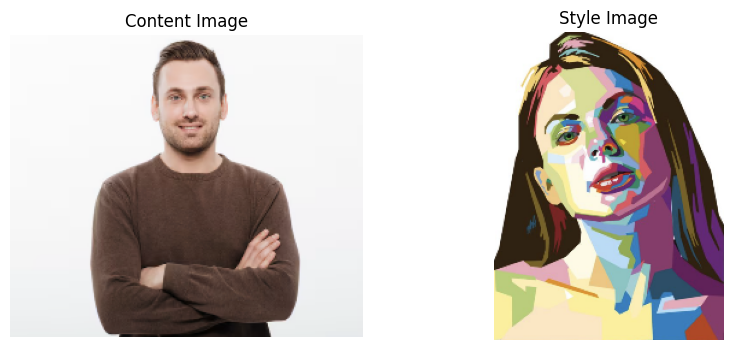

In [66]:
content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
show_image(content_image, "Content Image")

plt.subplot(1,2,2)
show_image(style_image, "Style Image")
plt.show()


In [67]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

In [68]:
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block3_conv1'
]

In [69]:
content_model = Model(vgg.input, vgg.get_layer(content_layer).output)

style_models = [
    Model(vgg.input, vgg.get_layer(layer).output)
    for layer in style_layers
]

In [70]:
def content_loss(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    return tf.reduce_mean(tf.square(a_C - a_G))

In [71]:
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    x = tf.reshape(tensor, [-1, channels])
    n = tf.shape(x)[0]
    gram = tf.matmul(x, x, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [72]:
def style_loss(style, generated):
    loss = 0
    weight = 1.0 / len(style_models)

    for model in style_models:
        S = gram_matrix(model(style))
        G = gram_matrix(model(generated))
        loss += weight * tf.reduce_mean(tf.square(S - G))

    return loss

In [73]:
@tf.function
def train_step(content, style, generated,optimizer, alpha, beta):
    with tf.GradientTape() as tape:
        c_loss = content_loss(content, generated)
        s_loss = style_loss(style, generated)
        total_loss = alpha * c_loss + beta * s_loss

    grads = tape.gradient(total_loss, generated)
    optimizer.apply_gradients([(grads, generated)])

    return total_loss


In [74]:
def neural_style_transfer(content_path, style_path,
                          iterations=100, alpha=10, beta=1000):

    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

    for i in range(iterations):
        total_loss = train_step(
            content, style, generated,
            optimizer, alpha, beta
        )

        if i % 10 == 0:
            print(f"Iteration {i}, Total Loss: {total_loss.numpy():.4e}")

    return generated.numpy()


Iteration 0, Total Loss: 1.2497e+12
Iteration 10, Total Loss: 1.2380e+12
Iteration 20, Total Loss: 1.2274e+12
Iteration 30, Total Loss: 1.2172e+12
Iteration 40, Total Loss: 1.2068e+12
Iteration 50, Total Loss: 1.1961e+12
Iteration 60, Total Loss: 1.1848e+12
Iteration 70, Total Loss: 1.1729e+12
Iteration 80, Total Loss: 1.1603e+12
Iteration 90, Total Loss: 1.1470e+12


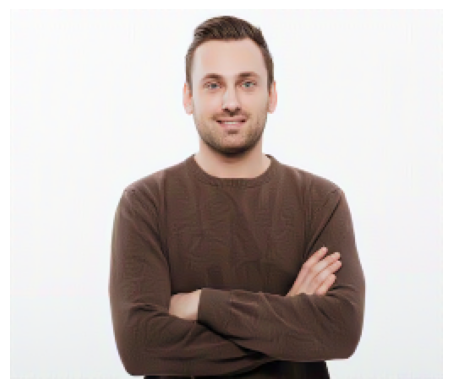

In [75]:
final_image = neural_style_transfer(content_path, style_path, iterations=100)
show_image(final_image)
plt.show()